In [1]:
%matplotlib inline
import os, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.distributions as torchD

import torch, seaborn as sns
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from utils import *
from AE_collection import *

## Load Dataset

In [2]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [3]:
batch_size = 128

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../data/", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="../data/", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = [1, 28, 28]
enc_dim = 400
latent_dim = 2
num_epochs = 50
logDir = "models_and_stats/"

## Load models

In [5]:
model_names = ["MLP_AE_l2", "MLP_VAE_dist_l2_wkl_10_wr_1", "MLP_VAE_dist_l2_wkl_10_wr_0", "MLP_CVAE_dist_l2_wkl_10_wr_1"]
short_names = ["recon only (AE)", "recon + kl", "kl only", "CVAE"]
model1 = MLP_AE(input_shape=input_shape, latent_dim=latent_dim)
model2 = MLP_VAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
model3 = MLP_VAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
model4 = MLP_CVAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
models = [model1, model2, model3, model4]
results_dicts = []
for i in range(len(models)):
    print("loading model for {}".format(model_names[i]))
    model = models[i]
    model_path = logDir + model_names[i] + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    dict_name = model_names[i] + '.pkl'
    results_dicts.append(pickle.load(open(logDir + dict_name, 'rb'))) 

loading model for MLP_AE_l2
loading model for MLP_VAE_dist_l2_wkl_10_wr_1
loading model for MLP_VAE_dist_l2_wkl_10_wr_0
loading model for MLP_CVAE_dist_l2_wkl_10_wr_1


### 1. compare latent space

In [6]:
# plot the whole test latent space
all_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)
all_test_imgs, all_test_labels = next(iter(all_test_loader))
all_test_imgs, all_test_labels = torch.tensor(all_test_imgs).float().to(device), torch.tensor(all_test_labels).to(device)

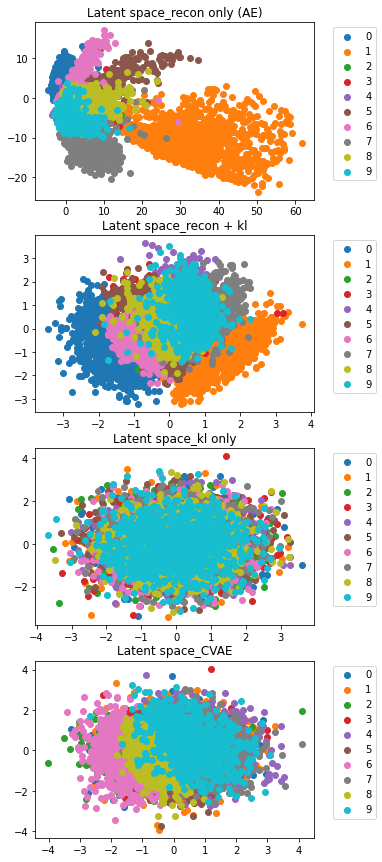

In [7]:
all_test_latents_list = []
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(5,15))
for i in range(len(models)):
    model = models[i]
    if i == 0: # AE
        all_test_latents, all_test_reconstructions = model(all_test_imgs)
    elif i == 3: # CVAE
        all_test_latents, all_test_reconstructions, all_test_latent_means, all_test_latent_logvars = model(all_test_imgs, all_test_labels)
    else: # VAE
        all_test_latents, all_test_reconstructions, all_test_latent_means, all_test_latent_logvars = model(all_test_imgs)
    plot_latent(all_test_labels, all_test_latents, dtype="tensor", suptitle_app="_{}".format(short_names[i]), ax=axes[i], add_legend=True)
    
    all_test_latents_list.append(all_test_latents)

### 2. plot VAE latent distribution

Plot bivariate latent distributions
pz batch_shape torch.Size([10, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([10, 2]), event_shape torch.Size([])
check p, q shape, pz (1000, 10, 2), qzx (1000, 10, 2)


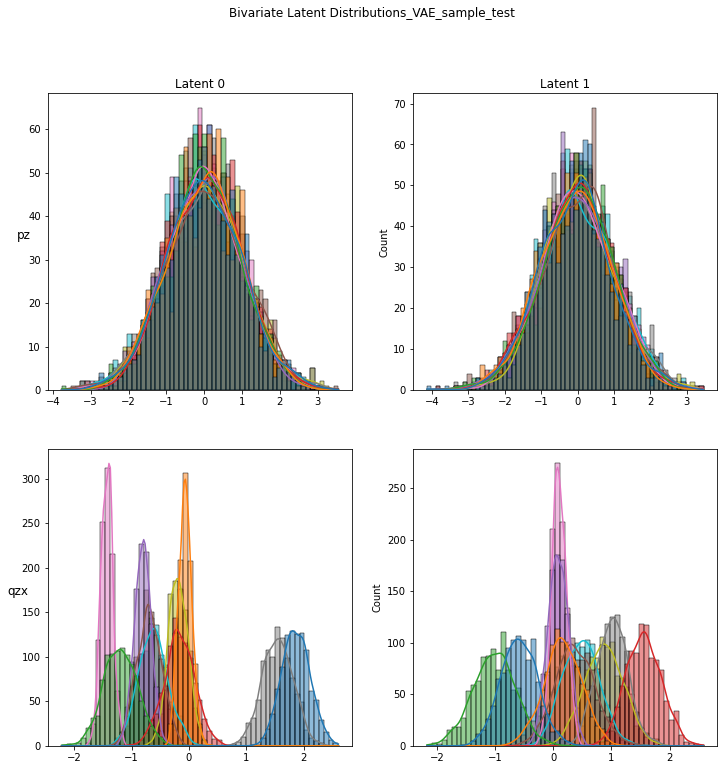

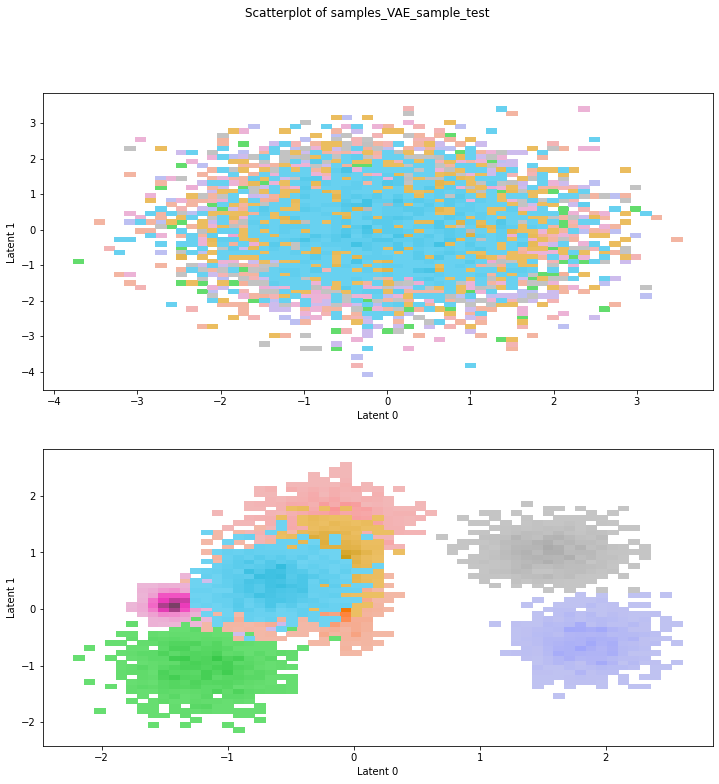

In [8]:
num_sample = 10
sample_test_imgs, sample_test_labels = all_test_imgs[:num_sample,...], all_test_labels[:num_sample,...]
VAE = models[1]
sample_test_latents, sample_test_reconstructions, sample_test_latent_mean, sample_test_latent_logvar = VAE(sample_test_imgs)
plot_p_q(sample_test_latent_mean, sample_test_latent_logvar, N_samples=1000, suptitle_app="_VAE_sample_test")

### 3. compare sampling around
Assume gaussian distribution for each latent variable, <br/>
AE takes latent as mean, std=1 <br/>
VAE takes latent mean & var <br/>

In [9]:
num_sample = 10 # number of images
sample_test_imgs, sample_test_labels = all_test_imgs[:num_sample,...], all_test_labels[:num_sample,...]
AE = models[0]
VAE = models[1]
N_samples = 10 # number of samples drawn from latent space
sample_test_latents_AE, sample_test_reconstruction_AE = AE(sample_test_imgs)
_, sample_test_reconstruction_VAE, sample_test_latent_mean_VAE, sample_test_latent_logvar_VAE = VAE(sample_test_imgs)

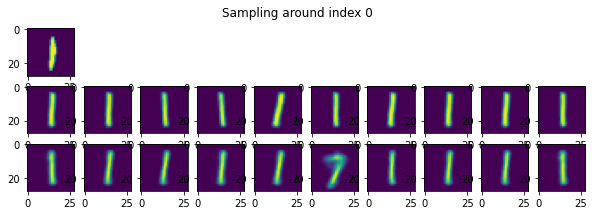

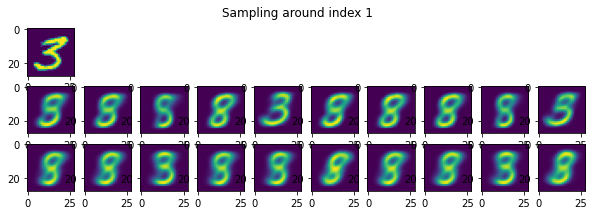

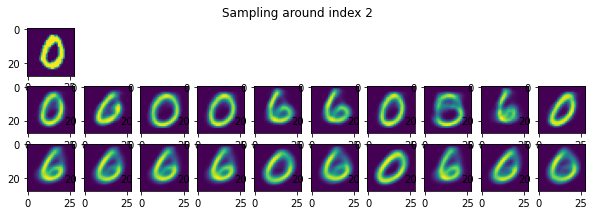

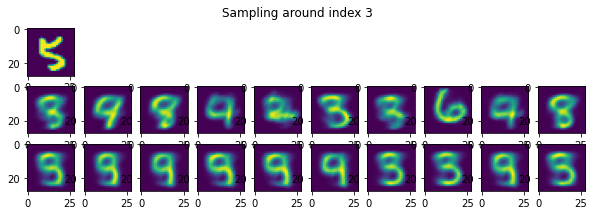

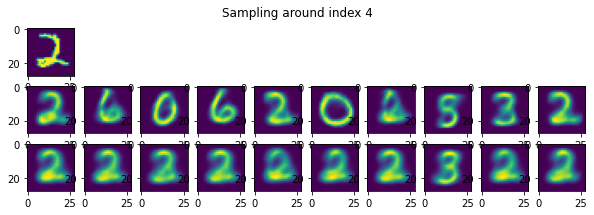

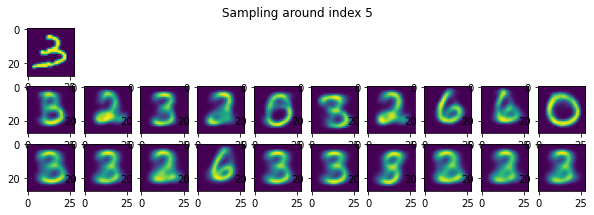

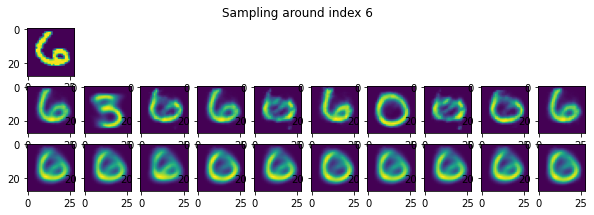

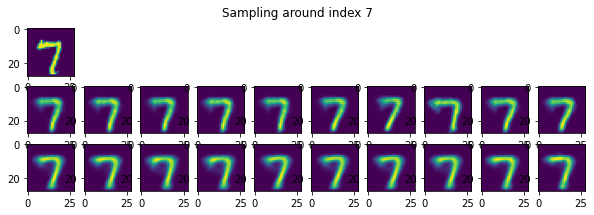

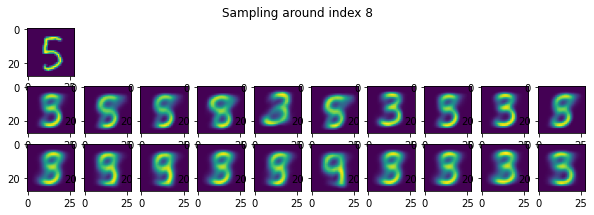

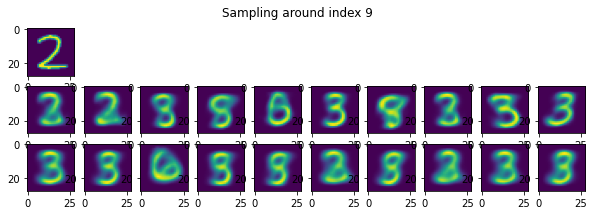

In [10]:
rows = ["original image", "AE recon", "VAE recon"]
n_rows = 3
for index in np.arange(num_sample):
    latent_AE = sample_test_latents_AE[index]
    sample_z_AE = sample_latent_embedding(latent_AE, sd=1, N_samples=N_samples-1)
    recon_sample_z_AE = AE.decoder(sample_z_AE)
    
    latent_VAE_mean = sample_test_latent_mean_VAE[index]
    latent_VAE_logvar = sample_test_latent_logvar_VAE[index]
    latent_VAE_std = torch.exp(0.5*latent_VAE_logvar)
    sample_z_VAE = sample_latent_embedding(latent_VAE_mean, sd=latent_VAE_std, N_samples=N_samples-1)
    recon_sample_z_VAE = VAE.decoder(sample_z_VAE)
    
#     figure, axes = plt.subplots(nrows=3, ncols=N_samples, figsize=(N_samples,3))
    figure = plt.figure(figsize=(N_samples,3))
    figure.suptitle("Sampling around index {}".format(index))
    img = sample_test_imgs[index].cpu().detach().numpy()
    reconstruction_AE = sample_test_reconstruction_AE[index].cpu().detach().numpy()
    reconstruction_VAE = sample_test_reconstruction_VAE[index].cpu().detach().numpy()
    
    plt.subplot(3, N_samples, 1)
    plt.imshow(img[0])
    
    plt.subplot(3, N_samples, N_samples+1)
    plt.imshow(reconstruction_AE[0])    
    for i, recon in enumerate(recon_sample_z_AE.cpu().detach().numpy()):
        plt.subplot(3, N_samples, N_samples+i+2)
        plt.imshow(recon[0])
        
    plt.subplot(3, N_samples, 2*N_samples+1)
    plt.imshow(reconstruction_VAE[0])    
    for i, recon in enumerate(recon_sample_z_VAE.cpu().detach().numpy()):
        plt.subplot(3, N_samples, 2*N_samples+i+2)
        plt.imshow(recon[0])
        
#     for ax, row in zip(axes[:,0], rows):
#         ax.set_ylabel(row, rotation=0, size='large')
#     plt.show()

#     for i in range(n_rows):
#         axes[i][0].text(x = -0.8, y = 5, s = rows[i], rotation = 90, va = "center")
#     plt.show()

### 4. plot CVAE reconstruction, given labels

In [11]:
CVAE = models[3]

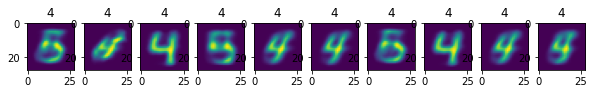

In [12]:
y = 4
generate_data_cond_y(CVAE, y, num_samples=10, latent_dim=2, device=device)

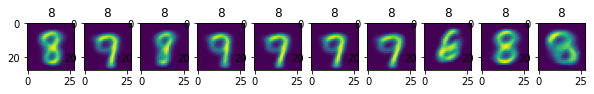

In [13]:
y = 8
generate_data_cond_y(model, y, num_samples=10, latent_dim=2, device=device)

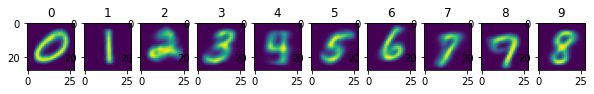

In [14]:
y = np.arange(10)
generate_data_cond_y(model, y, latent_dim=2, device=device)